In [2]:
%load_ext autoreload

In [3]:
%autoreload 2
from collections import defaultdict
from datetime import datetime
import h5py
import matplotlib.pyplot as plt
from neural_analysis.matIO import loadmat
import numpy as np
import os
import pandas as pd
from scipy.signal import butter, filtfilt, freqz
import sys
import time
from tqdm.auto import tqdm

sys.path.append('../..')
from ld_utils import compute_eigs, get_data_sigma_norms
from up_down import get_up_down
from utils import get_binary_stimuli, get_sample_interval, load, save, to_string

## Load Neural Data

In [4]:
# filename = '../../__data__/Mary-Anesthesia-20160809-01.mat'
filename = r'/home/adameisen/millerdata/common/datasets/anesthesia/mat/propofolPuffTone/Mary-Anesthesia-20160809-01.mat'
# filename = r'/home/adameisen/millerdata/common/datasets/anesthesia/mat/propofolPuffTone/MrJones-Anesthesia-20160121-01.mat'
# filename = r'/home/adameisen/common/datasets/anesthesia/mat/propofolWakeUp/Mary-Anesthesia-20170203-02.mat'
print("Loading data ...")
start = time.process_time()
# electrode_info, lfp, lfp_schema, session_info, spike_times, unit_info = loadmat(filename, variables=['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'spikeTimes', 'unitInfo'], verbose=False)
electrode_info, lfp_schema, session_info, trial_inunit_info = loadmat(filename, variables=['electrodeInfo', 'lfpSchema', 'sessionInfo', 'unitInfo'], verbose=False)
dt = lfp_schema['smpInterval'][0]
# T = lfp.shape[0]

f = h5py.File(filename, 'r')
airPuff_binary, audio_binary = get_binary_stimuli(f)

print(f"Data loaded (took {time.process_time() - start:.2f} seconds)")

Loading data ...
Data loaded (took 2.32 seconds)


In [8]:
data_path = "../../__data__/VAR/Mary_Window_Testing"
# results[window]
# for window in [0.15, 0.25, 0.5, 1, 2.5, 5]:
#     stride = 500
#     results = load(os.path.join(data_path, f'results_window_{window}_stride_{stride}_PCA_dim_-1'))

# Plot Data

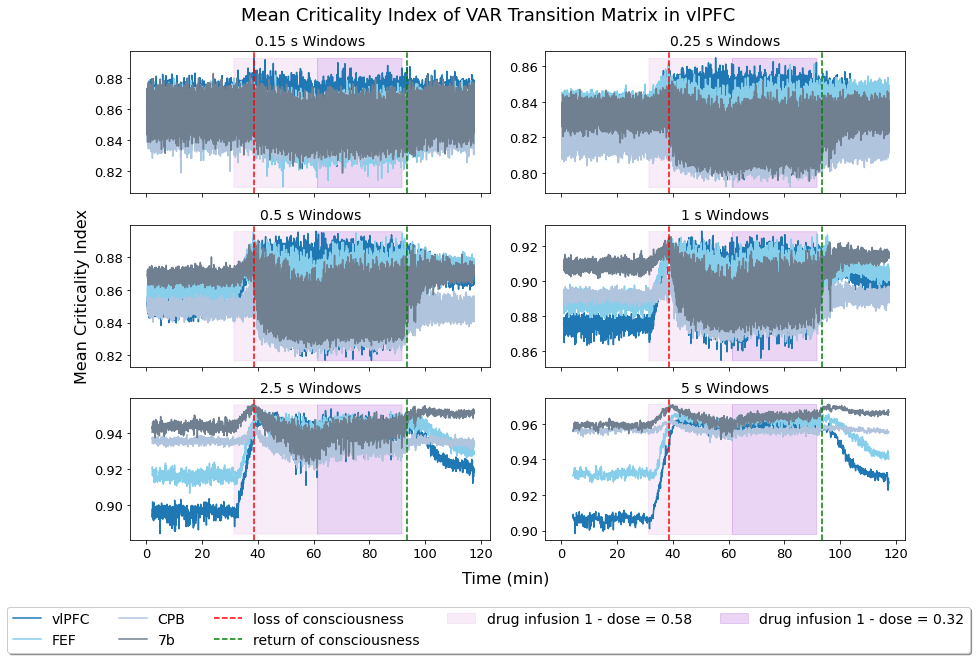

In [9]:
fig, axs = plt.subplots(3, 2, figsize=(12, 8), sharex=True)

for i, window in enumerate([0.15, 0.25, 0.5, 1, 2.5, 5]):
    ax = axs[int(i/2)][i % 2]
    stride = window
    results = load(os.path.join(data_path, f'results_window_{window}_stride_{stride}_PCA_dim_-1'))

    min_val = np.Inf
    max_val = -np.Inf
    for area, c in [('vlPFC', 'C0'), ('FEF', 'skyblue'), ('CPB', 'lightsteelblue'), ('7b', 'slategray')]:
        start_times = np.arange(results[area]['eigs'].shape[0])*stride/60
        
        criticality_inds = results[area]['eigs'].mean(axis=1)

        start_ind = 50
        start_times = start_times[start_ind:]
        criticality_inds = criticality_inds[start_ind:]
        ax.plot(start_times, criticality_inds, c=c, label=area)
        
        if criticality_inds.min() < min_val:
            min_val = criticality_inds.min()
        if criticality_inds.max() > max_val:
            max_val = criticality_inds.max()
    
    ax.set_title(f"{window} s Windows", fontsize=14)
    if (i/2) == 1 and i % 2 == 0:
        ax.set_ylabel('Mean Criticality Index', fontsize=16)
        
    
    ax.fill_between(np.arange(session_info['drugStart'][0], session_info['drugEnd'][0], stride)/60, 
                                min_val, max_val, color='plum', alpha=0.2, label=f"drug infusion 1 - dose = {session_info['drugDose'][0]}")
    ax.fill_between(np.arange(session_info['drugStart'][1], session_info['drugEnd'][1], stride)/60, 
                            min_val, max_val, color='darkorchid', alpha=0.2, label=f"drug infusion 1 - dose = {session_info['drugDose'][1]}")
    ax.tick_params(labelsize=13)
    
    ax.axvline(session_info['eyesClose'][-1]/60 if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose']/60, linestyle='--', c='red', label="loss of consciousness")
    ax.axvline(session_info['eyesOpen'][-1]/60 if isinstance(session_info['eyesOpen'], np.ndarray) else session_info['eyesOpen']/60, linestyle='--', c='green', label="return of consciousness")
    

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, fontsize=14, loc='upper center', ncol=5, bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True)      
#     if i % 2 == 0:
#         min_val = criticality_inds.min()
#         max_val = criticality_inds.max()
#     else: # i % 2 == 1
#         if criticality_inds.min() < min_val:
#             min_val = criticality_inds.min()
#         if criticality_inds.max() > max_val:
#             max_val = criticality_inds.max()
    
#         for ax in [axs[int(i/2)][0], axs[int(i/2)][1]]:
    
#             ax.fill_between(np.arange(session_info['drugStart'][0], session_info['drugEnd'][0], stride), 
#                                     min_val, max_val, color='C6', alpha=0.2, label='drug infusion 1')
#             ax.fill_between(np.arange(session_info['drugStart'][1], session_info['drugEnd'][1], stride), 
#                                     min_val, max_val, color='C7', alpha=0.2, label='drug infusion 2')

        
fig.text(0.52, -0.02, 'Time (min)', ha='center', fontsize=16)
plt.suptitle("Mean Criticality Index of VAR Transition Matrix in vlPFC", fontsize=18)
plt.tight_layout()
plt.show()

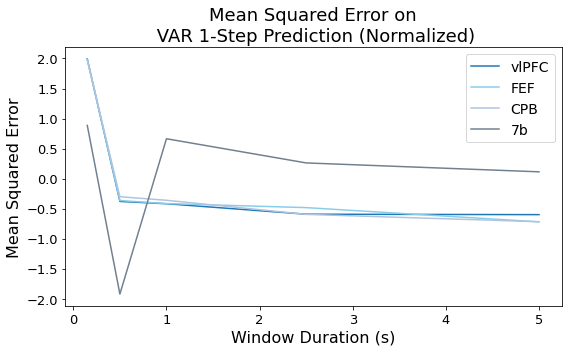

In [20]:
fig = plt.figure(figsize=(8, 5))

windows = [0.15, 0.5, 1, 2.5, 5]
# windows = [0.15, 0.5, 1]


for area, c in [('vlPFC', 'C0'), ('FEF', 'skyblue'), ('CPB', 'lightsteelblue'), ('7b', 'slategray')]:
# for area, c in [('FEF', 'C0')]:
    mse = []
    for i, window in enumerate(windows):
        stride = window
        results = load(os.path.join(data_path, f'results_window_{window}_stride_{stride}_PCA_dim_-1'))
        mse.append(results[area]['mse'].mean())
    mse = np.array(mse)
    mse -= mse.mean()
    mse /= mse.std()

    start_times = np.arange(results['all']['eigs'].shape[0])*window
    plt.plot(windows, mse, c=c, label=area)
plt.xlabel('Window Duration (s)', fontsize=16)
plt.ylabel('Mean Squared Error', fontsize=16)
plt.title("Mean Squared Error on\n VAR 1-Step Prediction (Normalized)", fontsize=18)
ax=plt.gca()
ax.tick_params(labelsize=13)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()